Poniższe ćwiczenie obrazuje użycie metod bagging i boosting do trenowania modeli uczenia maszynowego. Obie rodziny metod znane są pod nazwą klasyfikacji grupowej (ang. *ensemble methods*)

  * **bagging**: polega na niezależnym wytrenowaniu zbioru słabych klasyfikatorów, których odpowiedzi są następnie uśredniane. Jeśli błędy popełniane przez klasyfikatory są od siebie niezależne, to użycie zbioru klasyfikatorów istotnie obniża prawdopodobieństwo popełnienia błędu przez większość
  * **boosting**: polega na sukcesywnym trenowaniu kolejnych klasyfikatorów, każdy kolejny klasyfikator otrzymuje na wejście listę błędów popełnionych przez poprzedni klasyfikator

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

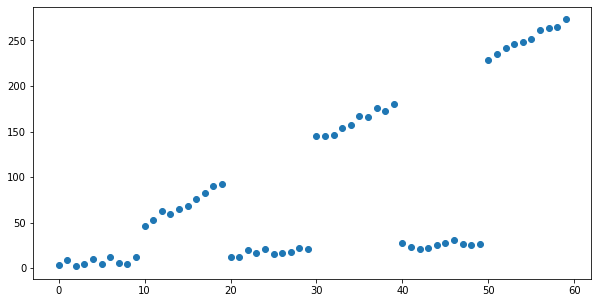

In [2]:
# generowanie sztucznych danych

generate = lambda x: x / 2 + (x // 10) % 2 * 20 * x / 5 + np.random.random() * 10

X = np.arange(0, 60).reshape(-1,1)
y = [generate(x)[0] for x in X]

plt.figure(figsize=(10, 5))
plt.scatter(X, y)
plt.show()

## Boosting

Pierwszym modelem jaki przetestujemy będzie najprostszy model liniowy

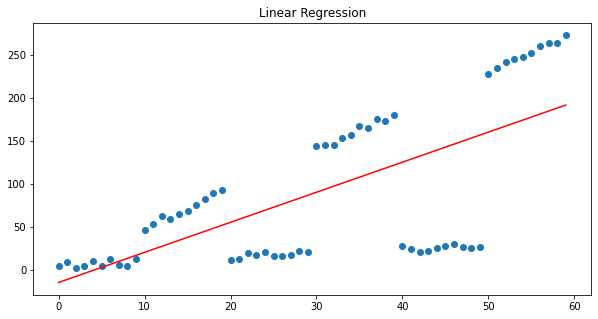

In [3]:
from sklearn import linear_model

linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X,y)

plt.figure(figsize=(10, 5))
plt.title("Linear Regression")
plt.scatter(X, y)
plt.plot(X, linear_regressor.predict(X), color='r')
plt.show()

Żeby zbadać jakość modelu narysujmy wartości resztowe

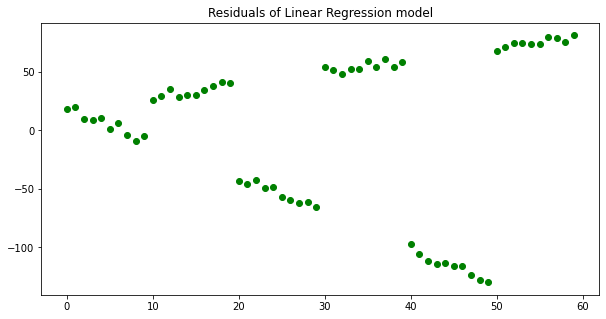

In [4]:
plt.figure(figsize=(10, 5))
plt.title("Residuals of Linear Regression model")
plt.scatter(X, y - linear_regressor.predict(X), color='green')
plt.show()

Spróbujemy poprawić powyższy model korzystając z techniki *boosting*. Zaczniemy od najprostszego modelu składającego się z jednego drzewa decyzyjnego o głębokości 1

In [5]:
from sklearn import ensemble

params = {
    'n_estimators': 1,
    'max_depth': 1,
    'learning_rate': 1,
    'criterion': 'mse'
}

gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)
gradient_boosting_regressor.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

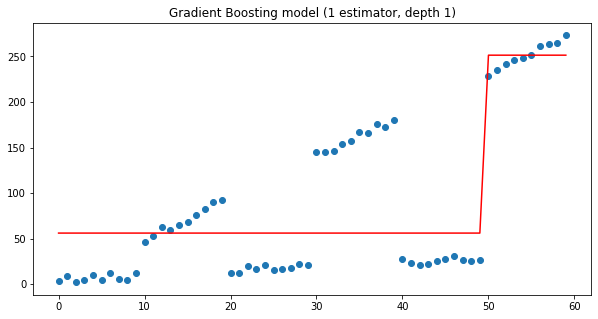

In [6]:
plt.figure(figsize=(10, 5))
plt.title('Gradient Boosting model (1 estimator, depth 1)')
plt.scatter(X, y)
plt.plot(X, gradient_boosting_regressor.predict(X), color='r')
plt.show()

Jeszcze raz spróbujmy obejrzeć wartości resztowe

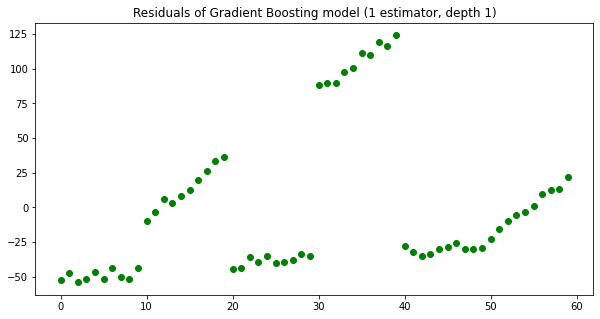

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Residuals of Gradient Boosting model (1 estimator, depth 1)")
plt.scatter(X, y - gradient_boosting_regressor.predict(X), color='green')
plt.show()

Jak widać, w przedziale [30,40] model popełnia bardzo duże błędy. Można im zapobiec dodając kolejny model do sekwencji.

In [8]:
params['n_estimators'] = 2

gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)
gradient_boosting_regressor.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

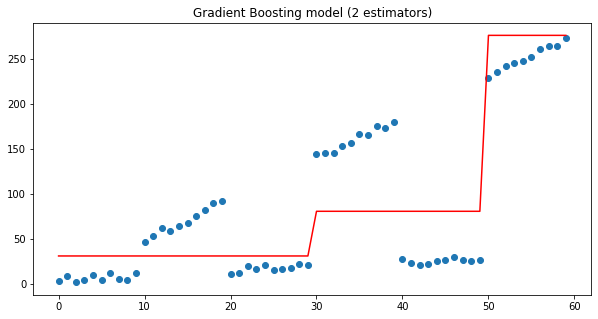

In [9]:
plt.figure(figsize=(10, 5))
plt.title('Gradient Boosting model (2 estimators)')
plt.scatter(X, y)
plt.plot(X, gradient_boosting_regressor.predict(X), color='r')
plt.show()

Jak widać, drugie drzewa działa dla X=30 i generuje tam nową wartość. Możemy zatem spróbować dopasować wiele estymatorów w sekwencji

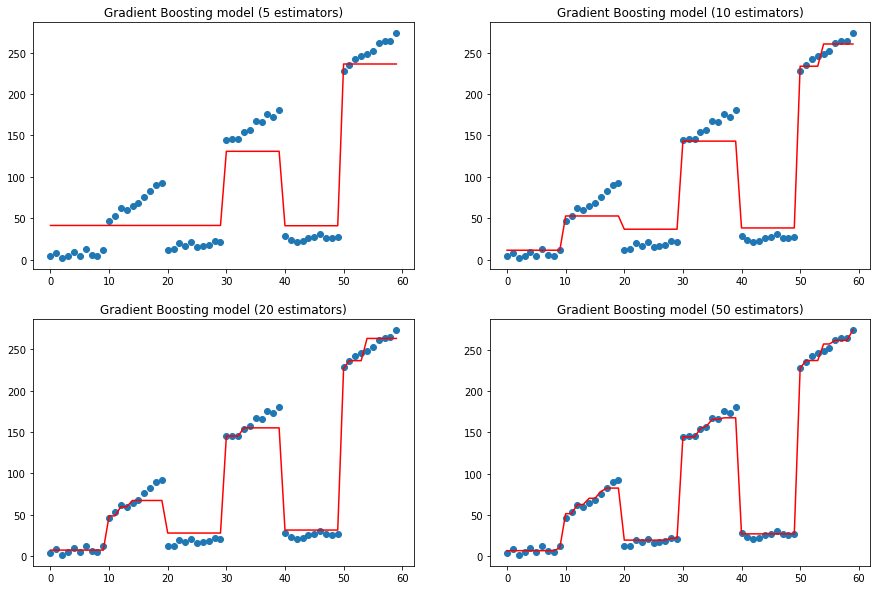

In [10]:
f, ax = plt.subplots(2, 2, figsize=(15, 10))

for idx, n_estimators in enumerate([5, 10, 20, 50]):
    params['n_estimators'] = n_estimators

    gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)

    gradient_boosting_regressor.fit(X, y)
    subplot = ax[idx // 2][idx % 2]
    subplot.set_title(f'Gradient Boosting model ({n_estimators} estimators)')
    subplot.scatter(X, y)
    subplot.plot(X, gradient_boosting_regressor.predict(X), color='r')
plt.show()

Zobaczmy, co się stanie, jeśli dla ustalonej liczby drzew pozwolimy indywidualnym drzewom znajdować więcej niż 1 punkt podziału

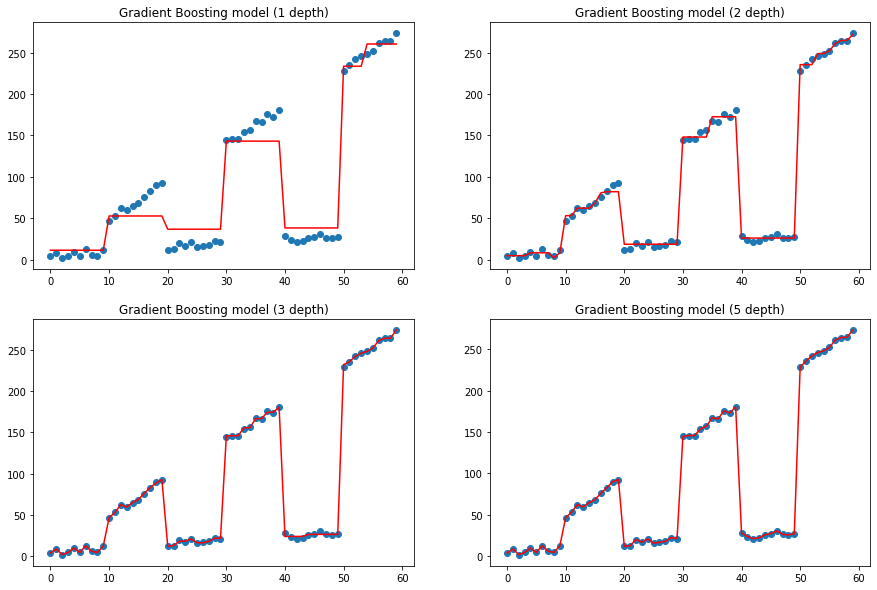

In [11]:
params['n_estimators'] = 10

f, ax = plt.subplots(2, 2, figsize=(15, 10))

for idx, max_depth in enumerate([1, 2, 3, 5]):
    params['max_depth'] = max_depth

    gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)

    gradient_boosting_regressor.fit(X, y)
    subplot = ax[idx // 2][idx % 2]
    subplot.set_title(f'Gradient Boosting model ({max_depth} depth)')
    subplot.scatter(X, y)
    subplot.plot(X, gradient_boosting_regressor.predict(X), color='r')
plt.show()

## Bagging

Jako przykład metody *bagging* użyjemy najprostszej wersji metody, która buduje pewną liczbę modeli tego samego typu, za każdym razem używając próbki typu *bootstrap*, w której ze zbioru *n* elementów losujemy n-krotnie element ze zwracaniem. W uzyskanej w ten sposób próbce około $(1-\frac{1}{e})=63.2\%$ elementów jest unikalnych.

In [12]:
from sklearn import tree

params = {
    'base_estimator': tree.DecisionTreeRegressor(),
    'n_estimators': 100
}

bagging_regressor = ensemble.BaggingRegressor(**params)
bagging_regressor.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=T

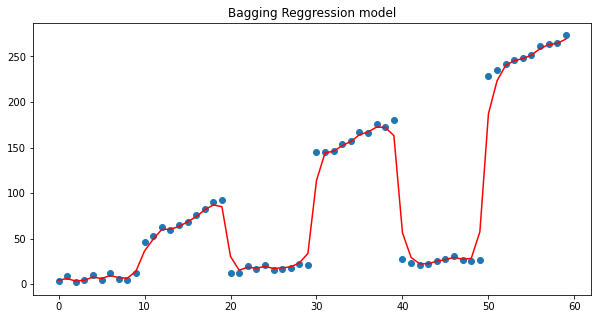

In [16]:
plt.figure(figsize=(10, 5))
plt.title('Bagging Reggression model')
plt.scatter(X, y)
plt.plot(X, bagging_regressor.predict(X), color='r')
plt.show()

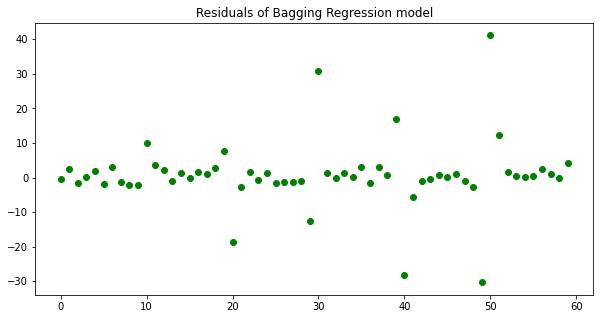

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Residuals of Bagging Regression model")
plt.scatter(X, y - bagging_regressor.predict(X), color='green')
plt.show()

Alternatywą dla takiego podejścia jest dobrze już znana technika losowych lasów

In [14]:
params = {
    'max_depth': 5,
    'n_estimators': 100,
    'criterion': 'mse'
}

random_forest_regressor = ensemble.RandomForestRegressor(**params)
random_forest_regressor.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

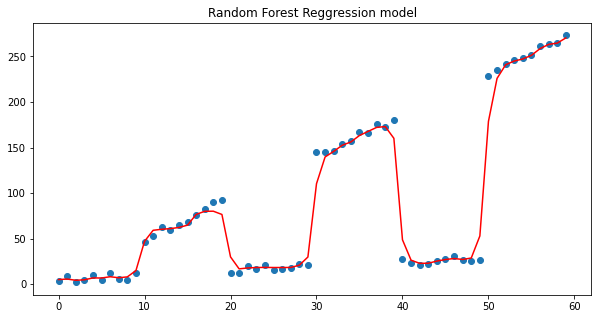

In [17]:
plt.figure(figsize=(10, 5))
plt.title('Random Forest Reggression model')
plt.scatter(X, y)
plt.plot(X, random_forest_regressor.predict(X), color='r')
plt.show()

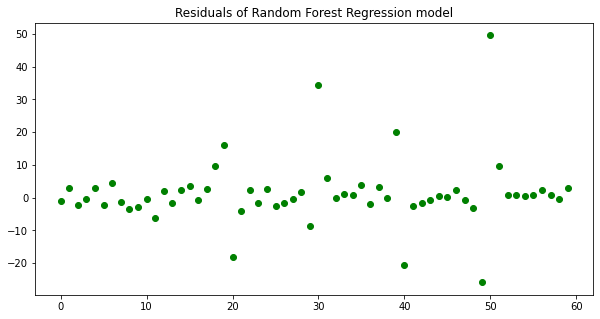

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Residuals of Random Forest Regression model")
plt.scatter(X, y - random_forest_regressor.predict(X), color='green')
plt.show()